In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from dateutil.parser import parse
import time
from datetime import datetime, timezone
from dateutil import parser
import oandapyV20.endpoints.instruments as instruments
import configparser
import json
from oandapyV20 import API
import oandapyV20.endpoints.positions as positions
import oandapyV20.endpoints.trades as trades
from oandapyV20.endpoints.pricing import PricingStream
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.accounts as accounts
from oandapyV20.contrib.factories import InstrumentsCandlesFactory

In [2]:
#https://oanda-api-v20.readthedocs.io/en/latest/index.html
config = configparser.ConfigParser()
config.read('oanda.cfg')

client = API(access_token=config['oanda']['access_token'])

In [3]:
def get_data(_from, _to, granularity, instrument, save_csv=False):
    """
        Collect historical data for training
        _from="2018-01-01 00:00"    date and time to start collecting candles
        _to=""                      date and time to end the collection of candles, if "", then end will be now.
        save_csv if True will save csv file in current folder
    """
    if _to == "":
        _to = datetime.strptime(datetime.now().isoformat()[0:19] + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    else:
        _to = datetime.strptime(parser.parse(_to).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
    "granularity": granularity,
    "from": datetime.strptime(parser.parse(_from).isoformat() + "Z", '%Y-%m-%dT%H:%M:%SZ').strftime('%Y-%m-%dT%H:%M:%SZ'),
    "to": _to
    }
    
    df = pd.DataFrame(columns=["Date", 'Open', 'High', 'Low', 'Close', "Volume"])
    for r in InstrumentsCandlesFactory(instrument=instrument, params=params):
        rv = client.request(r)

        results = [{"Date":candle['time'][0:19], "Open":float(candle['mid']['o']),
                    "High":float(candle['mid']['h']), "Low":float(candle['mid']['l']),
                   "Close":float(candle['mid']['c']), "Volume": float(candle['volume'])
                   } for candle in r.response.get('candles')]
        df = df.append(pd.DataFrame(results), ignore_index=True)
    
    df.set_index("Date", inplace=True)
    if save_csv:
        df.to_csv(instrument + "_" + granularity + ".csv")
    return df

In [4]:
start = "2020-01-10 00:00"    #date and time to start collecting candles
end = ""                      #date and time to end the collection of candles, if "", then end will be now.
granularity = "H2"
instrument = "EU50_EUR"

In [5]:
df = get_data(_from=start, _to=end, granularity=granularity, instrument=instrument, save_csv=False)
#df = pd.read_csv("EUR_USD_M15.csv", index_col=0)
print(df.shape)
df.head()

(5983, 5)


,Open,High,Low,Close,Volume
Date,,,,,
2020-01-10T00:00:00,3802.2,3807.2,3801.2,3803.2,614.0
2020-01-10T02:00:00,3803.7,3805.2,3800.2,3804.2,375.0
2020-01-10T04:00:00,3805.1,3807.2,3804.2,3807.2,253.0
2020-01-10T06:00:00,3806.3,3807.7,3801.4,3805.2,392.0
2020-01-10T08:00:00,3804.9,3805.2,3787.2,3799.2,739.0


In [6]:
import talib as ta
from talib import MA_Type

def generate_features(df):

    df_new = pd.DataFrame()
    
    # rolling mean ist das Beste Feature für SVM!
    
    df_new['Close'] = df['Close'].rolling(window=7).mean() 
    df_new['Close2'] = df['Close']
    df_new['Open'] = df['Open'].rolling(window=7).mean() 
    df_new['High'] = df['High'].rolling(window=7).mean()  
    df_new['Low'] = df['Low'].rolling(window=7).mean()    
    df_new['Volume'] = df['Volume'].rolling(window=7).mean()    
    df_new['MFI_5'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=5)
    df_new['Open-Close'] = df['Open'] - df['Low']
    df_new['High-Low'] = df['High'] - df['Close']
    
   

    
  
    df_new = df_new.dropna(axis=0)
    return df_new

In [7]:
df = generate_features(df)
df.tail()

,Close,Close2,Open,High,Low,Volume,MFI_5,Open-Close,High-Low
Date,,,,,,,,,
2022-02-24T12:00:00,3824.114286,3788.6,3844.900000,3866.300000,3799.100000,3523.000000,21.210706,31.6,29.4
2022-02-24T14:00:00,3810.500000,3826.0,3823.900000,3855.185714,3782.771429,3856.714286,36.152298,5.8,33.0
2022-02-24T16:00:00,3807.757143,3810.6,3810.042857,3842.500000,3779.885714,3632.142857,59.315728,17.9,25.4
2022-02-24T18:00:00,3816.085714,3882.6,3807.257143,3847.928571,3779.114286,3255.000000,41.952560,3.5,3.0
2022-02-24T20:00:00,3832.471429,3905.3,3815.442857,3860.185714,3797.114286,1974.000000,60.381065,1.5,15.8


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5977 entries, 2020-01-10T12:00:00 to 2022-02-24T20:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       5977 non-null   float64
 1   Close2      5977 non-null   float64
 2   Open        5977 non-null   float64
 3   High        5977 non-null   float64
 4   Low         5977 non-null   float64
 5   Volume      5977 non-null   float64
 6   MFI_5       5977 non-null   float64
 7   Open-Close  5977 non-null   float64
 8   High-Low    5977 non-null   float64
dtypes: float64(9)
memory usage: 467.0+ KB


In [9]:
df.head()

,Close,Close2,Open,High,Low,Volume,MFI_5,Open-Close,High-Low
Date,,,,,,,,,
2020-01-10T12:00:00,3802.628571,3799.2,3803.242857,3805.414286,3797.514286,441.714286,24.174130,7.9,2.0
2020-01-10T14:00:00,3801.914286,3798.2,3802.728571,3804.985714,3796.657143,400.000000,26.566615,3.4,6.0
2020-01-10T16:00:00,3799.914286,3790.2,3802.071429,3804.271429,3794.514286,367.000000,30.004174,13.9,10.0
2020-01-10T18:00:00,3796.628571,3784.2,3800.042857,3802.128571,3791.514286,334.857143,47.590903,7.7,8.0
2020-01-10T20:00:00,3792.771429,3778.2,3796.828571,3798.771429,3787.771429,289.142857,31.289877,8.6,6.0


In [10]:
# hier bei sigma muss ich noch herumprobieren. aber das macht auch einen Unterschied.
# C ist für die Regulierung und Gamma für den Einfluss einer einzelnen Trainingseinheit
# Gamma ist sehr wichtig, wichtiger als C

sigma = 11
gamma = 1/(2 * sigma **2)



Y = np.where(df['Close'].shift(-2) > df['Close'],1,-1)
X = df[['Open-Close', 'High-Low', 'MFI_5']]

split_percentage = 0.7
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
Y_train = Y[:split]

# Test data set
X_test = X[split:]
Y_test = Y[split:]
#print(Df)
cls = SVC(kernel = 'rbf', gamma = gamma, C = 5, decision_function_shape = 'ovr').fit(X_train, Y_train)
accuracy_train = accuracy_score(Y_train, cls.predict(X_train))
accuracy_test = accuracy_score(Y_test, cls.predict(X_test))

print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 78.96%
Test Accuracy: 77.65%


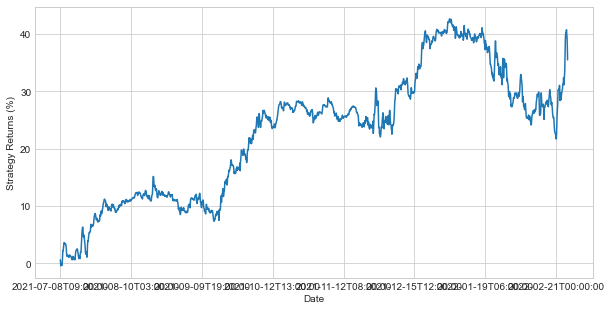

In [11]:
# Backtest 1

df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.Close2.shift(-2) / df.Close2)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

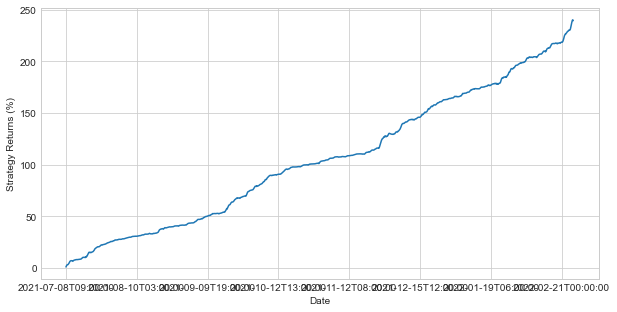

In [12]:
# Backtest 2

df['Predicted_Signal'] = cls.predict(X)
# Calculate log returns
df['Return'] = np.log(df.Close.shift(-2) / df.Close)*100
df['Strategy_Return'] = df.Return * df.Predicted_Signal
df.Strategy_Return.iloc[split:].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [13]:

X=df[['Open-Close','High-Low', 'MFI_5']][-1:]
position = int(cls.predict(X))

In [14]:
print(position)

1


<AxesSubplot:xlabel='Date'>

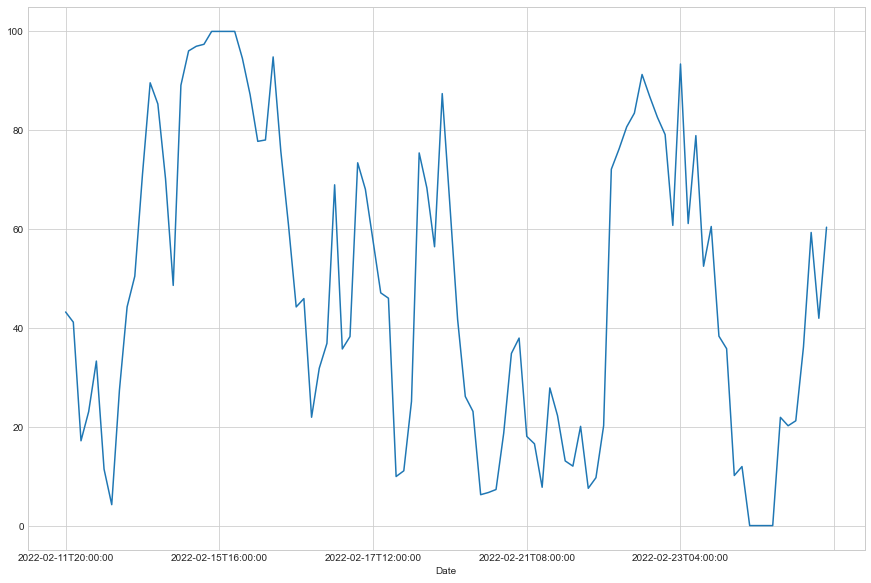

In [15]:
df['MFI_5'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

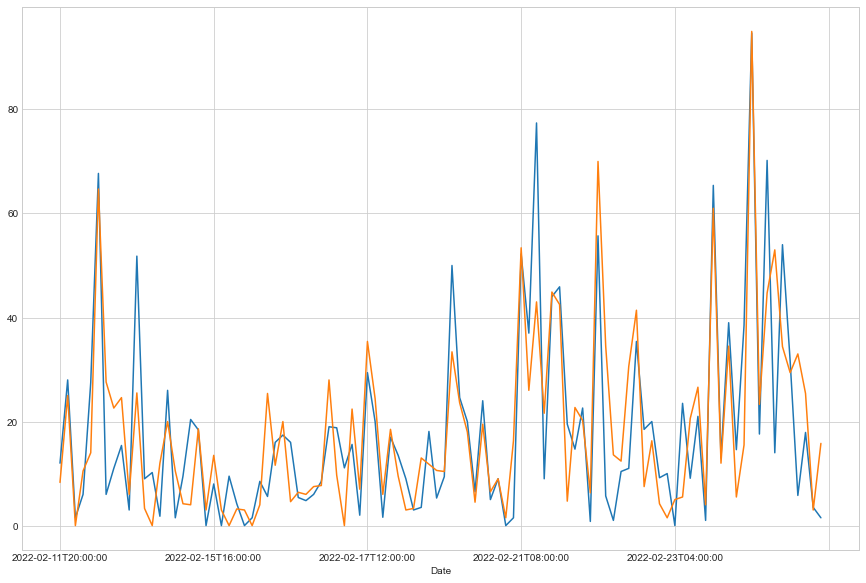

In [16]:
df['Open-Close'][-100:].plot(figsize=(15,10))
df['High-Low'][-100:].plot(figsize=(15,10))

<AxesSubplot:xlabel='Date'>

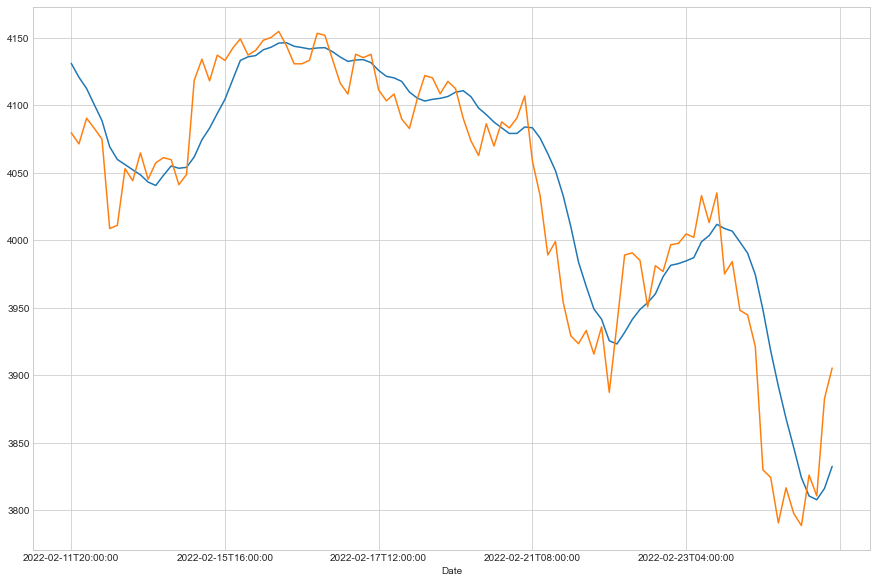

In [17]:
df['Close'][-100:].plot(figsize=(15,10))
df['Close2'][-100:].plot(figsize=(15,10))